In [42]:
import pandas as pd
import h5py
import numpy as np
import glob
import cartopy.crs as ccrs
import pyart
from cartopy import geodesic
import shapely
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

def read_stn_info(state):

        names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
        if state=="vic_nsw":
                stn_df1 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
                stn_df2 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nsw_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
                stn_df = pd.concat([stn_df1, stn_df2], axis=0)
        else:
                stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
                    names=names, header=0)
        stn_df["y1"] = pd.to_numeric(stn_df.y1, errors="coerce")
        stn_df["y2"] = pd.to_numeric(stn_df.y2, errors="coerce")

        return stn_df


def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def return_drop_list(state):

        #Contains lists of stations to drop from each state. Generally either too high above sea level, or offshore.    

        assert state in ["qld","nsw","vic","sa","wa","vic_nsw"]

        if state=="qld":
                return [41175, 200840, 200601, 200736, 200783, 200701, 200831, 200732, 200704, 200001,\
                                200283, 39122, 39059, 27058, 27054,
                       40927, 40926, 40925, 40043]
        elif state=="vic":
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344]
        elif state=="nsw":
                return [56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196,
                       66062] #Sydney observatory is manually dropped here, but is automatically dropped
                                # in post_process_tracks.py as it is not QC'd
        elif state=="wa":
                return [9091,9193,9255,9256]
        elif state=="sa":
                return []
        elif state=="vic_nsw":
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344, 56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196]



In [43]:
def station_stats(state, file_id, start_year, max_stn_dist=100):
    #Read station info
    stn_df = read_stn_info(state)

    #Read TINT-created grid, for the purpose of getting the radar metadata
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    lat0 = grid.attrs['source_origin_latitude']
    lon0 = grid.attrs['source_origin_longitude']

    #Calculate distance between radar and each station
    stn_df["dist_from_radar_km"] = latlon_dist(lat0, lon0, stn_df.lat.values, stn_df.lon.values)

    #Subset stations based on a max distance threshold, and having at least one year overlap with the radar data
    stn_df = stn_df[\
                        (stn_df.dist_from_radar_km <= max_stn_dist) &\
                        (stn_df.y2 >= int(start_year))]

    drops = stn_df[(np.in1d(stn_df.stn_no, return_drop_list(state)))]

    print("Percent QC: ",pd.to_numeric(stn_df["Y%"],errors="coerce").mean(),"\n")
    print("Total stations: ",stn_df.shape[0] - drops.shape[0],"\n")
    print("Dropped stations: \n",drops[["stn_no","stn_name","hgt_asl","lat","lon"]])
    
    return stn_df[(np.in1d(stn_df.stn_no, return_drop_list(state), invert=True))]

In [44]:
#Melbourne
state="vic"
file_id="2_20200101_20200131"
start_year = 2008
stns2 = station_stats(state,file_id,start_year)


Percent QC:  97.84375 

Total stations:  30 

Dropped stations: 
     stn_no                                  stn_name  hgt_asl      lat  \
21   86376  FAWKNER BEACON                               17.0 -37.9483   
76   86344  SOUTH CHANNEL ISLAND                          9.0 -38.3065   

         lon  
21  144.9269  
76  144.8016  


In [45]:
#Brisbane
state="qld"
file_id="66_20200101_20200131"
start_year = 2006
stns66 = station_stats(state,file_id,start_year)


Percent QC:  98.11764705882354 

Total stations:  13 

Dropped stations: 
      stn_no                                  stn_name  hgt_asl      lat  \
5     40925  BANANA BANK NORTH BEACON                      7.0 -27.5327   
24    40043  CAPE MORETON LIGHTHOUSE                      99.9 -27.0314   
59    40926  INNER RECIPROCAL MARKER                      10.0 -27.2633   
101   40927  SPITFIRE CHANNEL BEACON                       7.0 -27.0481   

          lon  
5    153.3333  
24   153.4661  
59   153.2419  
101  153.2664  


In [46]:
#Namoi
state="nsw"
file_id="69_20200101_20200131"
start_year = 2010
stns69 = station_stats(state,file_id,start_year)


Percent QC:  99.0 

Total stations:  5 

Dropped stations: 
 Empty DataFrame
Columns: [stn_no, stn_name, hgt_asl, lat, lon]
Index: []


In [47]:
#Perth
state="wa"
file_id="70_20200101_20200131"
start_year = 2013
stns70 = station_stats(state,file_id,start_year)


Percent QC:  97.52941176470588 

Total stations:  13 

Dropped stations: 
     stn_no                                  stn_name  hgt_asl      lat  \
22    9255  COLPOYS POINT                                 3.0 -32.2272   
34    9256  GARDEN ISLAND HSF                             6.0 -32.2433   
42    9091  INNER DOLPHIN PYLON                           0.0 -31.9889   
83    9193  ROTTNEST ISLAND                              43.1 -32.0069   

         lon  
22  115.6994  
34  115.6839  
42  115.8311  
83  115.5022  


In [48]:
#Sydney
state="nsw"
file_id="71_20200101_20200131"
start_year = 2009
stns71 = station_stats(state,file_id,start_year)

print("\n\nNOTE: SYDNEY (OBSERVATORY HILL) HAS ALMOST NO QUALITY CHECKED DATA. SO TOTAL STATIONS HERE IS REALLY 27")

Percent QC:  96.48275862068965 

Total stations:  27 

Dropped stations: 
      stn_no                                  stn_name  hgt_asl      lat  \
75    63292  MOUNT BOYCE AWS                            1080.0 -33.6185   
103   66062  SYDNEY (OBSERVATORY HILL)                    39.0 -33.8607   
109   66196  SYDNEY HARBOUR (WEDDING CAKE WEST)            6.0 -33.8405   

          lon  
75   150.2741  
103  151.2050  
109  151.2643  


NOTE: SYDNEY (OBSERVATORY HILL) HAS ALMOST NO QUALITY CHECKED DATA. SO TOTAL STATIONS HERE IS REALLY 27


In [50]:
print("total stations: ",30+13+5+13+27)
print("average Y%: ",(97.84375 + 98.11764705882354 + 99.0 + 97.52941176470588 + 96.48275862068965) / 5)

total stations:  88
average Y%:  97.79471348884381


In [40]:
def get_radar_latlon(file_id):
    
    #Read TINT-created grid, for the purpose of getting the radar metadata
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    
    lat0 = grid.attrs['source_origin_latitude']
    lon0 = grid.attrs['source_origin_longitude']
    
    return lat0, lon0

def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


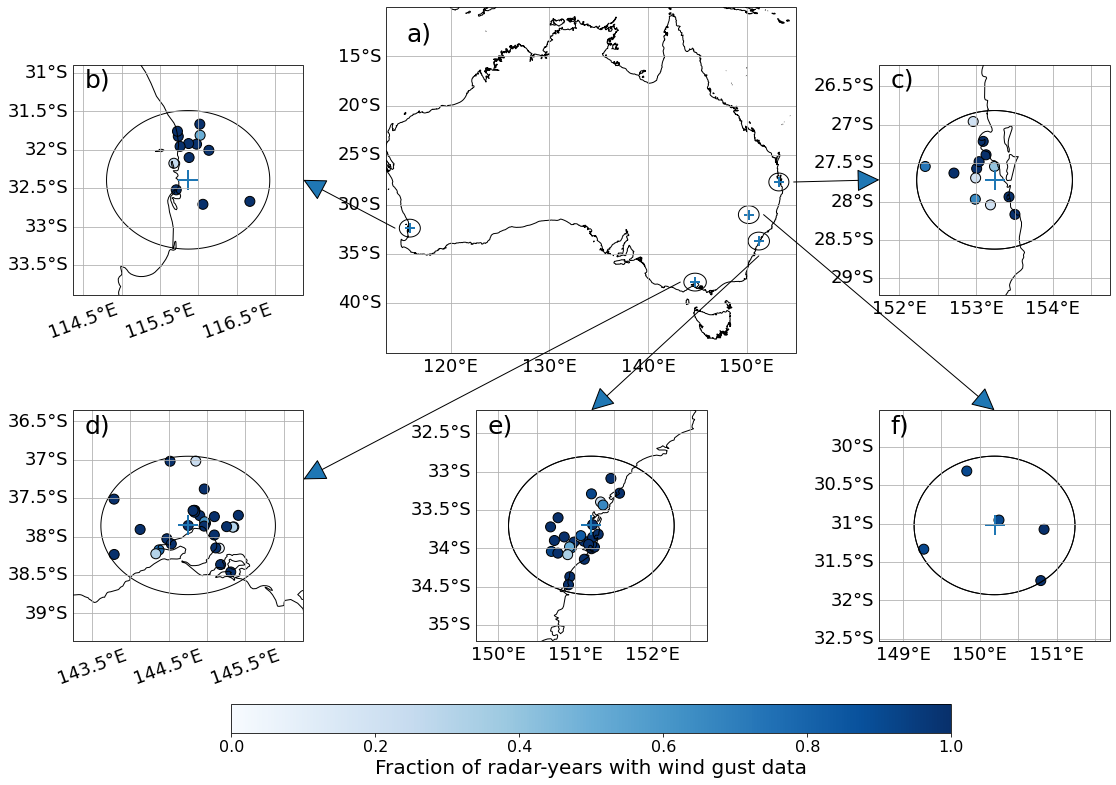

In [49]:
def plot_radar(ax,lons,lats,ms=20):
    
    for lon, lat in zip(lons,lats):
        plot_range_rings(lon,lat,100,ax)
        ax.plot(lon,lat,ms=ms,marker="+",mew=2,color="tab:blue")

def add_arrow(ax,sub_ax,lon,lat,sub_y=True,y=True,dlat=1.5,y_reverse=False,sub_y_reverse=False,a_style="-|>",sub_y_shift=0):
    
    #Define where the arrow is pointing to. Midway on x or y
    if sub_y:
        if sub_y_reverse:
            xy1 = (0,0.5+sub_y_shift)
        else:
            xy1 = (1,0.5+sub_y_shift)
    else:
        xy1 = (0.5,1)
        
    #Same but for the arrow origin
    if y:
        if y_reverse:
            xy2 = (lon+dlon,lat)
        else:
            xy2 = (lon-dlon,lat)
    else:
        xy2 = (lon,lat-dlat)
    con = ConnectionPatch(xyA=xy2, xyB=xy1, coordsA="data", coordsB="axes fraction",arrowstyle=a_style,mutation_scale=50,
                          axesA=ax, axesB=sub_ax)
    sub_ax.add_artist(con)        
        
def plot_stns(ax, stn_df, start_date):
    
    years = np.arange(start_date,2021)
    c=[np.in1d(years,np.arange(y1,y2+1)).sum() / ((years[-1]+1)-years[0]) \
         for y1, y2, qc in zip(stn_df.y1, stn_df.y2, pd.to_numeric(stn_df["Y%"],errors="coerce")/100)]

    s=ax.scatter(stn_df["lon"],stn_df["lat"],marker="o",s=100,c=c,cmap=plt.get_cmap("Blues"),edgecolor="k",vmin=0,vmax=1)
    return s
        
fig=plt.figure(figsize=[20,16])
b=0.6
dlon=1.5
dlat=1.5
lat2,lon2 = get_radar_latlon("2_20200101_20200131")
lat66,lon66 = get_radar_latlon("66_20200101_20200131")
lat69,lon69 = get_radar_latlon("69_20200101_20200131")
lat70,lon70 = get_radar_latlon("70_20200101_20200131")
lat71,lon71 = get_radar_latlon("71_20200101_20200131")


ax0 = plt.axes([0.3,b,0.3,0.3],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
plot_radar(ax0,[lon2,lon66,lon69,lon71,lon70],[lat2,lat66,lat69,lat71,lat70],ms=10)
ax0.coastlines("10m")
g=ax0.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax0.text(0.05,0.9,"a)",transform=ax0.transAxes,size=25)


ax1 = plt.axes([0.07,0.65,0.2,0.2],projection=ccrs.PlateCarree())
ax1.set_xlim([lon70-dlon,lon70+dlon])
ax1.set_ylim([lat70-dlat,lat70+dlat])
ax1.coastlines("10m")
g=ax1.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax1,[lon70],[lat70])
add_arrow(ax0,ax1,lon70,lat70,sub_y=True)
s=plot_stns(ax1, stns70, start_date=2013)
g.xlabel_style={"size":18,'rotation':20}
g.ylabel_style={"size":18}
ax1.text(0.05,0.9,"b)",transform=ax1.transAxes,size=25)

ax2 = plt.axes([0.07,0.35,0.2,0.2],projection=ccrs.PlateCarree())
ax2.set_xlim([lon2-dlon,lon2+dlon])
ax2.set_ylim([lat2-dlat,lat2+dlat])
ax2.coastlines("10m")
g=ax2.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax2,[lon2],[lat2])
add_arrow(ax0,ax2,lon2,lat2,sub_y=True,sub_y_shift=0.2)
s=plot_stns(ax2, stns2, start_date=2008)
g.xlabel_style={"size":18,'rotation':20}
g.ylabel_style={"size":18}
ax2.text(0.05,0.9,"d)",transform=ax2.transAxes,size=25)

ax3 = plt.axes([0.35,0.35,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon71, lat71, 100, ax3)
ax3.set_xlim([lon71-dlon,lon71+dlon])
ax3.set_ylim([lat71-dlat,lat71+dlat])
ax3.coastlines("10m")
g=ax3.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax3,[lon71],[lat71])
add_arrow(ax0,ax3,lon71,lat71,sub_y=False,y=False)
s=plot_stns(ax3, stns71, start_date=2009)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax3.text(0.05,0.9,"e)",transform=ax3.transAxes,size=25)

ax4 = plt.axes([0.63,0.35,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon69, lat69, 100, ax4)
ax4.set_xlim([lon69-dlon,lon69+dlon])
ax4.set_ylim([lat69-dlat,lat69+dlat])
ax4.coastlines("10m")
g=ax4.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax4,[lon69],[lat69])
add_arrow(ax0,ax4,lon69,lat69,sub_y=False,y=True,y_reverse=True)
s=plot_stns(ax4, stns69, start_date=2010)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax4.text(0.05,0.9,"f)",transform=ax4.transAxes,size=25)

ax5 = plt.axes([0.63,0.65,0.2,0.2],projection=ccrs.PlateCarree())
plot_range_rings(lon66, lat66, 100, ax5)
ax5.set_xlim([lon66-dlon,lon66+dlon])
ax5.set_ylim([lat66-dlat,lat66+dlat])
ax5.coastlines("10m")
g=ax5.gridlines(draw_labels=True); g.xlabels_top=False; g.ylabels_right=False
plot_radar(ax5,[lon66],[lat66])
add_arrow(ax0,ax5,lon66,lat66,sub_y=True,y=True,y_reverse=True,sub_y_reverse=True)
s=plot_stns(ax5, stns66, start_date=2006)
g.xlabel_style={"size":18}
g.ylabel_style={"size":18}
ax5.text(0.05,0.9,"c)",transform=ax5.transAxes,size=25)

cax=plt.axes([0.2,0.27,0.5,0.025])
cb=plt.colorbar(s,orientation="horizontal",cax=cax)
cb.set_label("Fraction of radar-years with wind gust data",size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/radar_locs.jpeg",dpi=800,bbox_inches="tight")


In [31]:
stns71

,id,stn_no,district,stn_name,site_open,site_close,lat,lon,latlon_method,state,...,y1,y2,comp%,Y%,N%,W%,S%,I%,#,dist_from_radar_km
2,st,67108,67,BADGERYS CREEK AWS,10/1995,,-33.8969,150.7281,GPS,NSW,...,2000,2021,90,95,5,0,0,0,#,49.546756
4,st,66137,66,BANKSTOWN AIRPORT AWS,01/1968,,-33.9176,150.9837,GPS,NSW,...,2000,2021,94,95,5,0,0,0,#,31.884525
7,st,68228,68,BELLAMBI AWS,11/1988,,-34.3691,150.9291,GPS,NSW,...,2000,2021,93,95,5,0,0,0,#,78.696901
14,st,68192,68,CAMDEN AIRPORT AWS,01/1943,,-34.0390,150.6890,GPS,NSW,...,2010,2021,99,99,*,0,0,0,#,61.032656
15,st,68257,68,CAMPBELLTOWN (MOUNT ANNAN),11/2006,,-34.0615,150.7735,GPS,NSW,...,2008,2021,98,99,*,0,0,0,#,56.832033
18,st,66194,66,CANTERBURY RACECOURSE AWS,10/1995,,-33.9057,151.1134,GPS,NSW,...,2000,2021,94,95,5,0,0,0,#,24.457284
29,st,61412,61,COORANBONG (LAKE MACQUARIE AWS),07/2008,,-33.0887,151.4636,GPS,NSW,...,2008,2021,88,99,*,0,0,0,#,72.060062
35,st,66022,66,FORT DENISON,01/1989,,-33.8551,151.2254,DEM 3 Sec SRTM,NSW,...,2000,2021,92,95,5,0,0,0,#,17.226394
38,st,61087,61,GOSFORD (NARARA RESEARCH STATION) AWS,01/1916,05/2013,-33.3949,151.3289,GPS,NSW,...,2011,2013,98,100,0,0,0,0,#,35.783135
39,st,61425,61,GOSFORD AWS,05/2013,,-33.4351,151.3614,GPS,NSW,...,2013,2021,99,99,*,0,0,0,#,32.739555
